In [1]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from itertools import permutations
from heapq import heappop, heappush

plt.rcParams['font.sans-serif'] = 'SimHei'

In [2]:
borrow_return_data = pd.read_csv('borrow_return_data.csv')
road_distance_data = pd.read_csv('road_distance_data.csv')

In [7]:
# 构建图表
def build_transposed_graph(borrow_data, road_data):
    G = nx.Graph()
    # 添加节点
    for idx, row in borrow_data.iterrows():
        G.add_node(row['楼宇名称'], borrow_count=row['借书数'], return_count=row['还书数'])
    # 获取节点列表
    nodes = borrow_data['楼宇名称'].tolist()

    # 遍历并添加边
    road_counter = 0
    for j in range(6):
        for i in range(5):
            start_node = nodes[i*6 + j]
            end_node = nodes[(i+1)*6 + j]
            road_name = road_data.iloc[road_counter]['道路名称']
            road_length = road_data.iloc[road_counter]['实际距离']
            G.add_edge(start_node, end_node, road=road_name, length=road_length)
            road_counter += 1

    for i in range(6):
        for j in range(5):
            start_node = nodes[i*6 + j]
            end_node = nodes[i*6 + j + 1]
            road_name = road_data.iloc[road_counter]['道路名称']
            road_length = road_data.iloc[road_counter]['实际距离']
            G.add_edge(start_node, end_node, road=road_name, length=road_length)
            road_counter += 1

    return G

G_transposed = build_transposed_graph(borrow_return_data, road_distance_data)

In [8]:
# Dijkstra算法查找最短路径
def find_shortest_path(G, start, end):
    distances = {node: float('inf') for node in G.nodes}
    distances[start] = 0
    prev = {node: None for node in G.nodes}
    pq = [(0, start)]

    while pq:
        current_distance, current_node = heappop(pq)

        if current_node == end:
            break

        for neighbor in G.neighbors(current_node):
            edge_length = G[current_node][neighbor]['length']
            new_distance = current_distance + edge_length

            if new_distance < distances[neighbor]:
                distances[neighbor] = new_distance
                prev[neighbor] = current_node
                heappush(pq, (new_distance, neighbor))

    path = []
    node = end
    while node is not None:
        path.append(node)
        node = prev[node]
    path.reverse()

    return path, distances[end]


In [9]:
# 动态任务分配
def dynamic_task_assignment(G, nodes, speeds):
    A_route, B_route = ["充电站1"], ["充电站2"]
    A_capacity, B_capacity = 0, 0
    A_time, B_time = 0, 0

    remaining_nodes = set(nodes)

    while remaining_nodes:
        nearest_A = min(remaining_nodes, key=lambda node: find_shortest_path(G, A_route[-1], node)[1])
        nearest_B = min(remaining_nodes, key=lambda node: find_shortest_path(G, B_route[-1], node)[1])

        distance_A = find_shortest_path(G, A_route[-1], nearest_A)[1]
        distance_B = find_shortest_path(G, B_route[-1], nearest_B)[1]

        if distance_A <= distance_B:
            path_A, distance_A = find_shortest_path(G, A_route[-1], nearest_A)
            A_route.extend(path_A[1:])
            A_time += distance_A / speeds["A"]

            borrow_count = borrow_return_data[borrow_return_data['楼宇名称'] == nearest_A]['借书数'].values[0]
            return_count = borrow_return_data[borrow_return_data['楼宇名称'] == nearest_A]['还书数'].values[0]
            A_capacity += borrow_count + return_count

            remaining_nodes.remove(nearest_A)

            if A_capacity > 10:
                to_library, dist_to_library = find_shortest_path(G, A_route[-1], "图书馆")
                A_route.extend(to_library[1:])
                A_time += dist_to_library / speeds["A"]
                A_capacity = 0

        else:
            path_B, distance_B = find_shortest_path(G, B_route[-1], nearest_B)
            B_route.extend(path_B[1:])
            B_time += distance_B / speeds["B"]

            borrow_count = borrow_return_data[borrow_return_data['楼宇名称'] == nearest_B]['借书数'].values[0]
            return_count = borrow_return_data[borrow_return_data['楼宇名称'] == nearest_B]['还书数'].values[0]
            B_capacity += borrow_count + return_count

            remaining_nodes.remove(nearest_B)

            if B_capacity > 10:
                to_library, dist_to_library = find_shortest_path(G, B_route[-1], "图书馆")
                B_route.extend(to_library[1:])
                B_time += dist_to_library / speeds["B"]
                B_capacity = 0

    to_charging_A, dist_A = find_shortest_path(G, A_route[-1], "充电站1")
    A_route.extend(to_charging_A[1:])
    A_time += dist_A / speeds["A"]

    to_charging_B, dist_B = find_shortest_path(G, B_route[-1], "充电站2")
    B_route.extend(to_charging_B[1:])
    B_time += dist_B / speeds["B"]

    return A_route, B_route, A_time, B_time

nodes_to_visit = [node for node in borrow_return_data['楼宇名称'] if node not in ["充电站1", "充电站2", "图书馆"]]

speeds = {"A": 8, "B": 10}

In [11]:
A_route, B_route, A_time, B_time = dynamic_task_assignment(G_transposed, nodes_to_visit, speeds)

In [12]:
A_route, B_route, A_time, B_time

(['充电站1',
  '四美楼',
  '芳邻楼',
  '四美楼',
  '弥津楼',
  '映雪楼',
  '高洁楼',
  '图书馆',
  'T型路口',
  '俊采楼',
  '东隅楼',
  '长风楼',
  '汀兰楼',
  '绿竹楼',
  'T型路口',
  '图书馆',
  '十字路口',
  '朱华楼',
  '流丹楼',
  '俊采楼',
  'T型路口',
  '图书馆',
  '高洁楼',
  '凌云楼',
  '远山楼',
  '凌云楼',
  '芳邻楼',
  '四美楼',
  '弥津楼',
  '北辰楼',
  '秋水楼',
  '皎月楼',
  '秋水楼',
  '临川楼',
  '十字路口',
  '图书馆',
  '高洁楼',
  '凌云楼',
  '芳邻楼',
  '四美楼',
  '充电站1'],
 ['充电站2',
  '兰亭楼',
  '沉璧楼',
  '清风楼',
  '长洲楼',
  '清风楼',
  '景明楼',
  '图书馆',
  'T型路口',
  '绿竹楼',
  '景明楼',
  '图书馆',
  '高洁楼',
  '南溟楼',
  '长洲楼',
  '重霄楼',
  '长洲楼',
  '清风楼',
  '景明楼',
  '图书馆',
  '高洁楼',
  '映雪楼',
  '弥津楼',
  '北辰楼',
  '秋水楼',
  '临川楼',
  '十字路口',
  '图书馆',
  'T型路口',
  '俊采楼',
  '东隅楼',
  '万千楼',
  '星耀楼',
  '郁青楼',
  '星耀楼',
  '万千楼',
  '东隅楼',
  '俊采楼',
  'T型路口',
  '图书馆',
  '十字路口',
  '临川楼',
  '耸翠楼',
  '朝晖楼',
  '雅望楼',
  '朝晖楼',
  '耸翠楼',
  '朱华楼',
  '十字路口',
  '图书馆',
  'T型路口',
  '绿竹楼',
  '沉璧楼',
  '兰亭楼',
  '充电站2'],
 4.0625,
 4.1899999999999995)

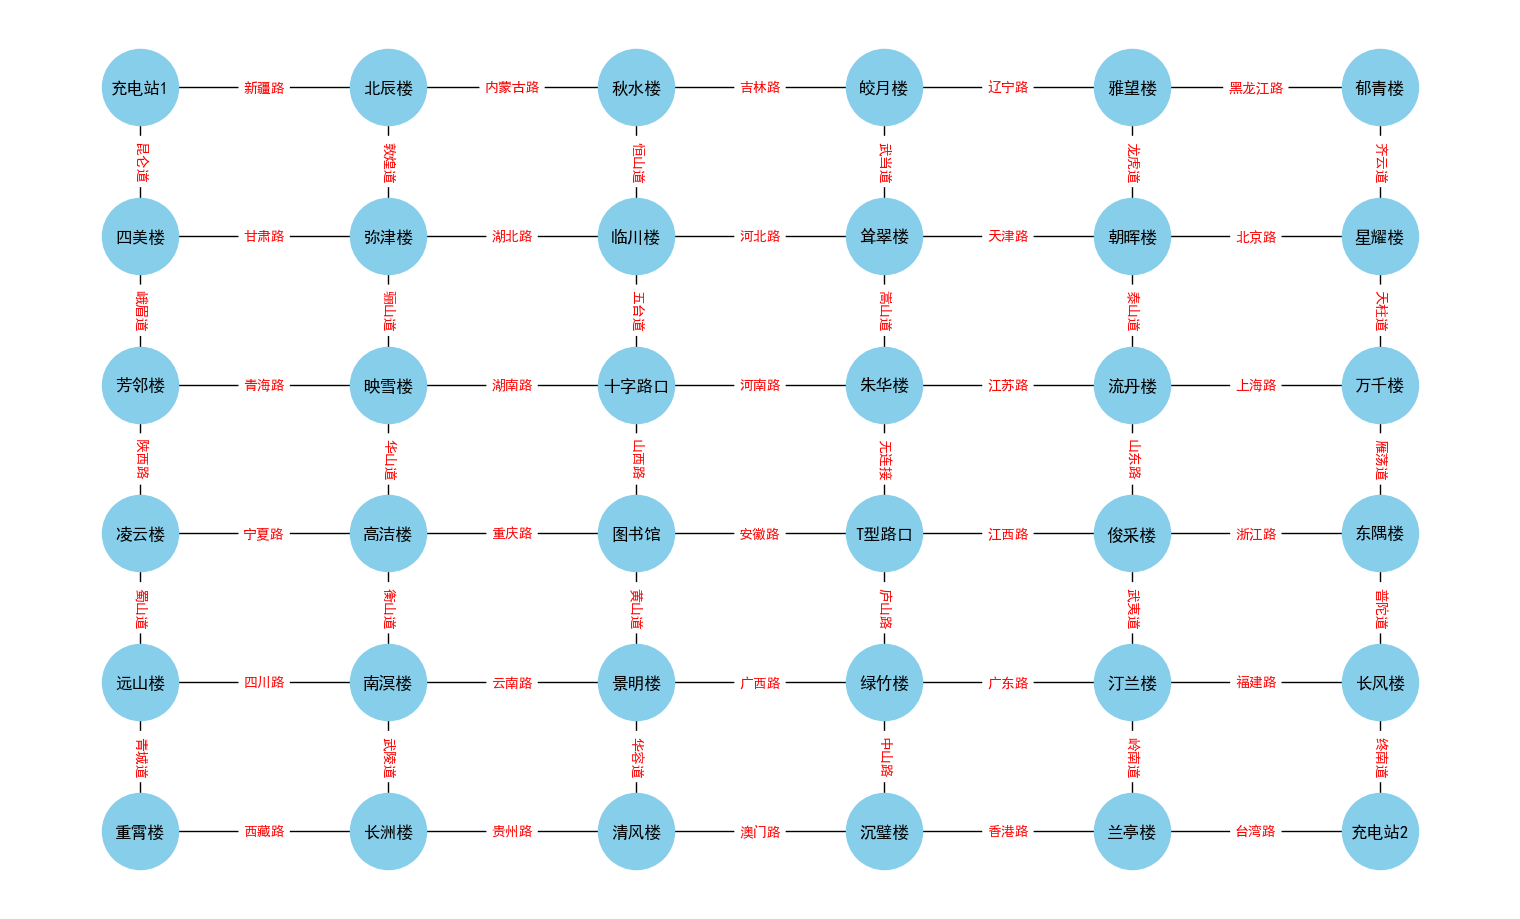

In [13]:
# 可视化图形
plt.figure(figsize=(15, 9))

# 准备转置位置和边标签
nodes = borrow_return_data['楼宇名称'].tolist()
transposed_positions = [(j, i) for i in range(6) for j in range(6)]
transposed_node_positions = dict(zip(nodes, transposed_positions))
transposed_pos = {node: (y, -x) for node, (x, y) in transposed_node_positions.items()}
edge_labels_transposed = nx.get_edge_attributes(G_transposed, 'road')

# 绘制图形
nx.draw(G_transposed, transposed_pos, with_labels=True, font_weight='bold', node_size=3000, node_color='skyblue')
nx.draw_networkx_edge_labels(G_transposed, transposed_pos, edge_labels=edge_labels_transposed, font_color='red')

plt.show()
